In [23]:
library(tidyverse)
library(caret)
library(AppliedPredictiveModeling)
library(Rtsne)
library(dplyr)
.libPaths("/root/R/x86_64-conda_cos6-linux-gnu-library/3.5")
library(cluster)
library(fpc)
library(gridExtra,quietly = T)
library(caret)
require(randomForest)
library(ROCR)
require(caTools)

PLS_varImp <- function(df){
    df$CaseControl <- as.factor(df$CaseControl)
    #df <- subset(df,select = -c(AlcoholAmount,Smoking,bcell,bmi_rrto,cd4t,cd8t,gran,mono,nk))
    myfolds <- createMultiFolds(df$CaseControl, k = 5, times = 10)
    control <- trainControl("repeatedcv", index = myfolds, selectionFunction = "oneSE")

    # Train PLS model
    mod1 <- train(CaseControl ~ ., data = df,
     method = "pls",
     metric = "Accuracy",
     tuneLength = 20,
     trControl = control,
     preProc = c("zv","center","scale"))
    # Check CV profile
    #plot(mod1)
    print(varImp(mod1))
}

RF_auc <- function(df){
    print(dim(df))
    aucs <-c()
    for(iter in 1:10){
        sample = sample.split(df$CaseControl, SplitRatio = .75)
        train = subset(df, sample == TRUE)
        test  = subset(df, sample == FALSE)
        rf_model=randomForest(as.factor(CaseControl) ~.,data = train,ntree=200,mtry=2,importance=TRUE)
        prediction <- predict(rf_model,subset(test,select = -c(CaseControl)))
        table(observed = test$CaseControl,predicted=prediction)
        # Calculate the probability of new observations belonging to each class
        # prediction_for_roc_curve will be a matrix with dimensions data_set_size x number_of_classes
        prediction_for_roc_curve <- predict(rf_model,subset(test,select = -c(CaseControl)),type="prob")
        # Use pretty colours:
        pretty_colours <- c("#F8766D")
        # Specify the different classes 
        classes <- levels(as.factor(test$CaseControl))
        # For each class
        i = 1
         # Define which observations belong to class[i]
        true_values <- ifelse(test$CaseControl==classes[i],2,1)
        pred <- prediction(prediction_for_roc_curve[,i],true_values)

        perf <- performance(pred, "tpr", "fpr")
        options(repr.plot.width=4, repr.plot.height=4)
        #plot(perf,main="ROC Curve",col="#F8766D") 
        auc.perf <- performance(pred, measure = "auc")
        #print(auc.perf@y.values)
        aucs <-c(aucs,auc.perf@y.values)
       
        }
     return(aucs)
}



# Loading ESS-MCCS Data

In [2]:
mccs_ess <- read.csv("/data/gunaseka/ESS_MCCS_Analysis/ess_mccs_data.csv",stringsAsFactors=FALSE)

dim(mccs_ess)

ess_siv_probs <- read.csv("/data/gunaseka/ESS_MCCS_Analysis/ESS_SIV_Probes.csv")

dim(ess_siv_probs)

[1] 6926 3836

[1] 2210   31

In [4]:
table(mccs_ess$CancerCellType)


    BC    CRC Kidney   Lung   MBCN     PC    UCC 
   866   1668    282    662    870   1726    852 

In [5]:
#select ProbIDs
probeIDs <-ess_siv_probs[c("CG","UCSC.browser.coordinates")]

select_columns <- c('CancerCellType','AlcoholAmount', 'CaseControl','Smoking','bcell','bmi_rrto','cd4t','cd8t','gran','mono','nk')


cancer_cases <- mccs_ess[mccs_ess$CaseControl!=1,]

myvars <- names(cancer_cases) %in% c('Sample','ID','AlcoholAmount','CaseControl','Smoking','bcell','bmi_rrto','cd4t','cd8t','gran','mono','nk')
cancer_cases_methy <- cancer_cases[!myvars]

cancer_cases_methy_ESS_SIV <- cancer_cases_methy[,ess_siv_probs$CG]

cancer_cases_methy_ESS_SIV_cg <- cancer_cases_methy_ESS_SIV[ , !(names(cancer_cases_methy_ESS_SIV) %in% c("CancerCellType"))]

nums <- unlist(lapply(cancer_cases_methy_ESS_SIV_cg, is.numeric))
cancer_cases_methy_ESS_SIV_cg <- cancer_cases_methy_ESS_SIV_cg[,nums]



cancer_cases_methy_ESS_SIV_cg <- cancer_cases_methy_ESS_SIV_cg[ , colSums(is.na(cancer_cases_methy_ESS_SIV_cg)) == 0]
head(cancer_cases_methy_ESS_SIV)
dim(cancer_cases_methy_ESS_SIV)


,cg03492136,cg25769590,cg23649088,cg25602718,cg07234508,cg24719726,cg03074188,cg00819233,cg05912338,cg07234876,⋯,cg19721055,cg20607798,cg20618651,cg21232488,cg03188948,cg18902978,cg19151808,cg25817165,cg25325723,cg21918786
1,3.411191,0.3822916,2.17572728,4.213013,1.1090564,3.428756,-1.958672,4.060164,0.7374268,5.3389623,⋯,5.130235,-1.169833,0.9873620,-0.2876672,-0.3630766,-4.068136,-0.34036082,0.9256159,4.852117,4.745145
4,3.903715,2.1439821,2.10445078,1.369702,7.9566586,3.315308,-1.279448,4.434092,2.9847213,0.8554057,⋯,8.580103,-1.965128,2.2590226,-1.0290855,-3.6314047,-3.877797,0.14849324,-0.1073317,1.392656,2.654273
5,4.069919,0.3436572,0.72483941,2.247164,0.2213000,2.674918,-1.477084,4.786576,1.1973321,3.8492824,⋯,5.548779,-3.528800,2.9440624,-1.3220859,-2.5553984,-4.388768,0.08583344,-0.5663364,3.326830,3.052435
8,4.371070,1.9953190,-1.03704535,1.067601,2.4695555,4.728938,-1.012473,4.856164,2.4445835,0.6763981,⋯,7.720827,-2.130468,-0.1501937,-0.7773924,-1.8589368,-3.852477,0.68247797,0.0605548,4.013712,3.625365
9,5.249979,0.6347563,-0.28127731,1.805233,-0.3626122,2.029848,-1.399338,1.024801,1.0270510,4.1247939,⋯,1.043619,-2.434710,1.1102838,-1.8842120,5.0117542,-4.243884,-0.59335249,-0.2965560,NA,5.022191
11,3.798693,2.4427495,0.03293707,2.014408,3.9910787,3.729533,-1.967829,5.168323,2.8096620,4.1399186,⋯,5.211337,-1.826182,2.6370324,-0.1554798,-1.4507748,-3.717704,0.28622605,1.2222834,3.058508,4.683261


[1] 3463 2210

In [6]:
set.seed(9)
tsne_model_1 = Rtsne(as.matrix(cancer_cases_methy_ESS_SIV_cg), check_duplicates=T, pca=T, perplexity=30, theta=0.5, dims=2)

[1] 3463    3

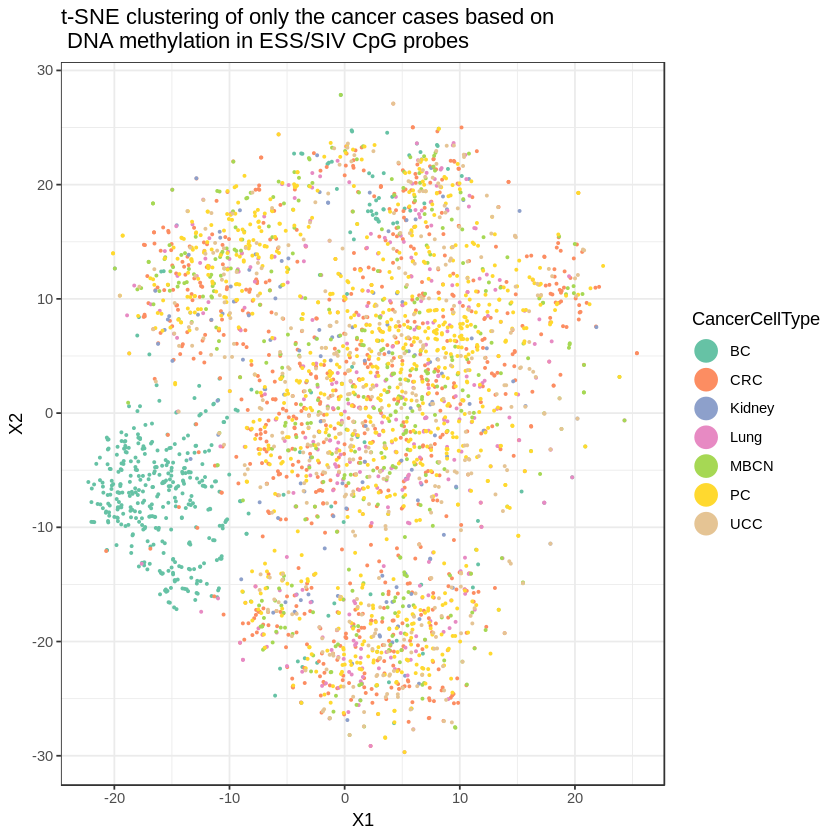

In [8]:
d_tsne_1 = as.data.frame(tsne_model_1$Y)

d_tsne_1$CancerCellType <- cancer_cases_methy_ESS_SIV$CancerCellType

#d_tsne_1$CancerCellType <- d_tsne_1$CancerCellType=="BC"
dim(d_tsne_1)

## plotting the results without clustering
ggplot(d_tsne_1, aes(x=V1, y=V2,colour = CancerCellType)) +
  geom_point(size=0.45) +
  guides(colour=guide_legend(override.aes=list(size=6))) +
  xlab("X1") + ylab("X2") +theme_bw()+
  ggtitle("t-SNE clustering of only the cancer cases based on \n DNA methylation in ESS/SIV CpG probes") +
  scale_colour_brewer(palette = "Set2")
#ggsave("cancer_case_control.png", width = 10, height = 8)

## tSNE plots considering cancer cases 

[1]  433 1626
[1] 433   3
[1]  834 1703


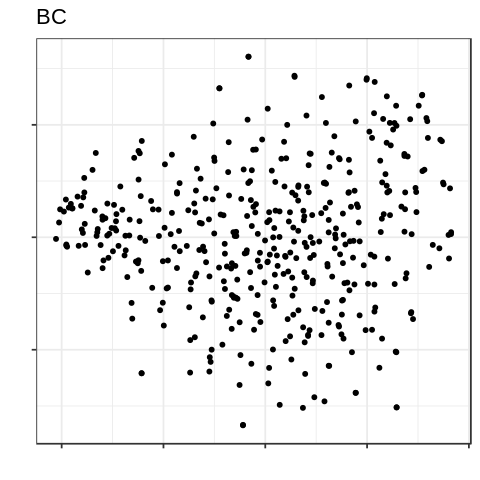

[1] 834   3
[1]  141 1989


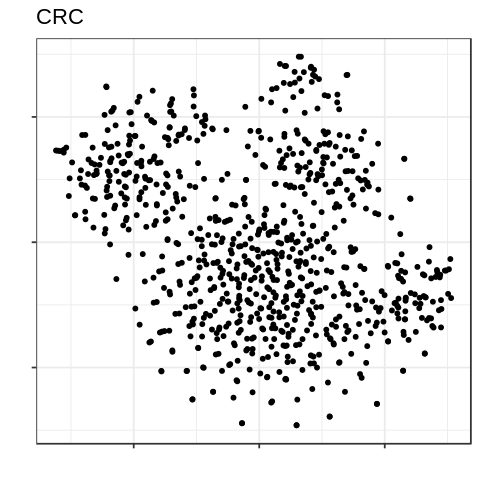

[1] 141   3
[1]  331 1927


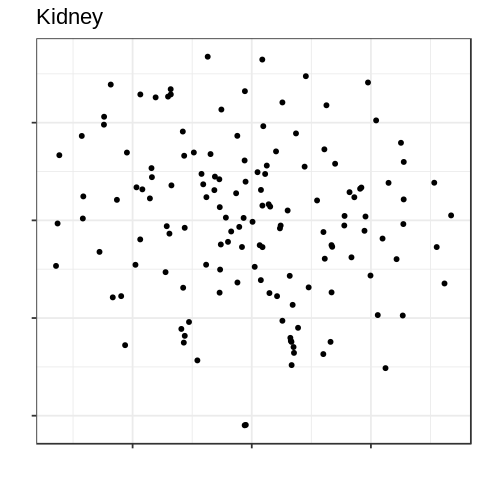

[1] 331   3
[1]  435 1867


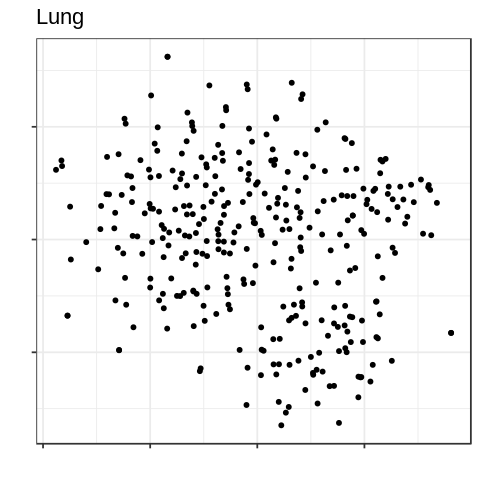

[1] 435   3
[1]  863 1720


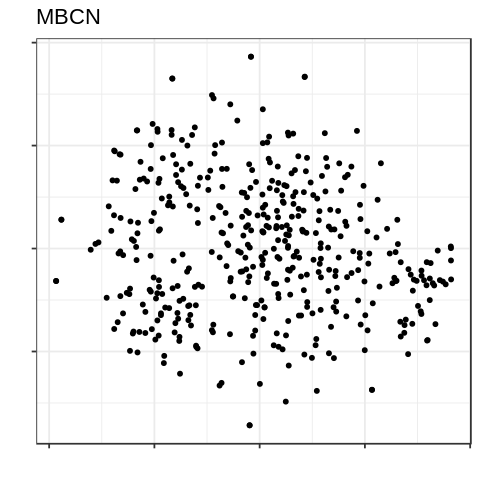

[1] 863   3
[1]  426 1880


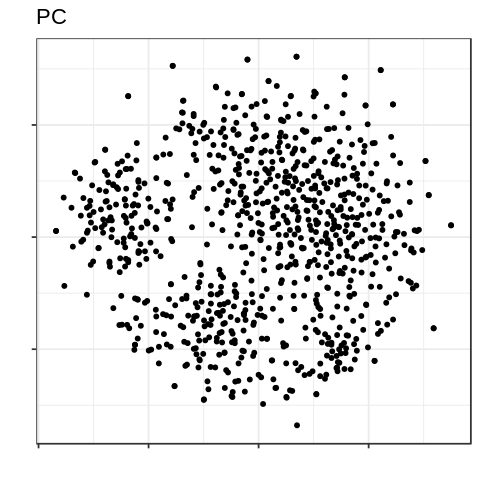

[1] 426   3


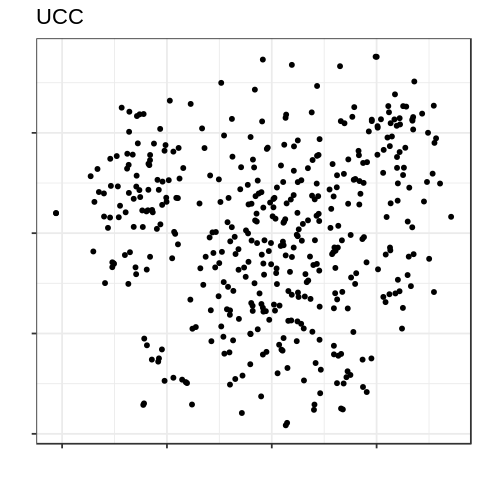

In [158]:
for (type in unique(cancer_cases_methy_ESS_SIV$CancerCellType)){
#type="BC"
BC_cases <- cancer_cases_methy_ESS_SIV[cancer_cases_methy_ESS_SIV$CancerCellType==type,]
BC_cases_cg <- BC_cases[ , !(names(BC_cases) %in% c("CancerCellType"))]
nums <- unlist(lapply(BC_cases_cg, is.numeric))
BC_cases_cg <- BC_cases_cg[,nums]
BC_cases_cg <- BC_cases_cg[ , colSums(is.na(BC_cases_cg)) == 0]
set.seed(9)
    print(dim(BC_cases_cg))
tsne_model_BC = Rtsne(as.matrix(BC_cases_cg), check_duplicates=FALSE, pca=TRUE, perplexity=30, theta=0.5, dims=2)
d_tsne_BC = as.data.frame(tsne_model_BC$Y)
d_tsne_BC$CancerCellType <- BC_cases$CancerCellType
## plotting the results without clustering
p <- ggplot(d_tsne_BC, aes(x=V1, y=V2)) +
  geom_point(size=1) +
  guides(colour=guide_legend(override.aes=list(size=6))) +
  xlab("") + ylab("") +theme_bw()+
  ggtitle(type) +
  theme(axis.text.x=element_blank(),
        axis.text.y=element_blank())
    print(p)
    print(dim(d_tsne_BC))
}

# Breast Cancer Case Clustering and Case/Control Classification

In [8]:
cancer_cases_controls <- mccs_ess[mccs_ess$CancerCellType=='BC',] 
cancer_cases <- mccs_ess[mccs_ess$CancerCellType=='BC' & mccs_ess$CaseControl==1,] 
cancer_cases_methy<- cancer_cases[,ess_siv_probs$CG]#do the clustering based on controls
dim(cancer_cases_methy)
nums <- unlist(lapply(cancer_cases_methy, is.numeric))
cancer_cases_methy <- cancer_cases_methy[,nums]
cancer_cases_methy <- cancer_cases_methy[ , colSums(is.na(cancer_cases_methy)) == 0]
set.seed(9)
tsne_model_3 = Rtsne(as.matrix(cancer_cases_methy), check_duplicates=T, pca=T, perplexity=30, theta=0.5, dims=3)
d_tsne_3 = as.data.frame(tsne_model_3$Y)

res <- dbscan::dbscan(d_tsne_3,eps = 3.3,minPts = 15)
#BC: 3.3
res

d_tsne_3$cluster <- res$cluster
d_tsne_3$ID <- cancer_cases$ID
head(d_tsne_3)
tsne_model_cluster1 <- d_tsne_3[d_tsne_3$cluster==1,]
tsne_model_cluster2 <- d_tsne_3[d_tsne_3$cluster==2,]
tsne_model_cluster3 <- d_tsne_3[d_tsne_3$cluster==3,]

tsne_model_cluster1_data <- merge(tsne_model_cluster1,cancer_cases_controls,on="ID")
tsne_model_cluster2_data <- merge(tsne_model_cluster2,cancer_cases_controls,on="ID")
tsne_model_cluster3_data <- merge(tsne_model_cluster3,cancer_cases_controls,on="ID")


cancer_cases_methy_c3<- tsne_model_cluster3_data[,ess_siv_probs$CG]
nums <- unlist(lapply(cancer_cases_methy_c3, is.numeric))
cancer_cases_methy_c3 <- cancer_cases_methy_c3[,nums]
cancer_cases_methy_c3 <- cancer_cases_methy_c3[ , colSums(is.na(cancer_cases_methy_c3)) == 0]
cancer_cases_methy_c3$CaseControl <- as.factor(tsne_model_cluster3_data$CaseControl)

cancer_cases_methy_c2<- tsne_model_cluster2_data[,ess_siv_probs$CG]
nums <- unlist(lapply(cancer_cases_methy_c2, is.numeric))
cancer_cases_methy_c2 <- cancer_cases_methy_c2[,nums]
cancer_cases_methy_c2 <- cancer_cases_methy_c2[ , colSums(is.na(cancer_cases_methy_c2)) == 0]
cancer_cases_methy_c2$CaseControl <- as.factor(tsne_model_cluster2_data$CaseControl)

cancer_cases_methy_c1<- tsne_model_cluster1_data[,ess_siv_probs$CG]
nums <- unlist(lapply(cancer_cases_methy_c1, is.numeric))
cancer_cases_methy_c1 <- cancer_cases_methy_c1[,nums]
cancer_cases_methy_c1 <- cancer_cases_methy_c1[ , colSums(is.na(cancer_cases_methy_c1)) == 0]
cancer_cases_methy_c1$CaseControl <- as.factor(tsne_model_cluster1_data$CaseControl)

summary(as.numeric(RF_auc(cancer_cases_methy_c1)))
summary(as.numeric(RF_auc(cancer_cases_methy_c2)))
summary(as.numeric(RF_auc(cancer_cases_methy_c3)))

PLS_varImp(cancer_cases_methy_c1)
PLS_varImp(cancer_cases_methy_c2)
PLS_varImp(cancer_cases_methy_c3)

[1]  433 2210

DBSCAN clustering for 433 objects.
Parameters: eps = 3.3, minPts = 15
The clustering contains 4 cluster(s) and 264 noise points.

  0   1   2   3   4 
264  66  27  60  16 

Available fields: cluster, eps, minPts

V1,V2,V3,cluster,ID
9.920316,-2.244555,-7.163024,0,BC_Pair_1
2.168514,-6.898777,-7.013702,0,BC_Pair_2
5.255325,-9.474140,3.572372,0,BC_Pair_3
-10.542062,-7.325307,3.635192,3,BC_Pair_4
14.142393,-2.562861,-4.184599,0,BC_Pair_5
1.940885,-7.875566,-1.463836,0,BC_Pair_6


,V1,V2,V3,cluster,ID
7,5.1738493,-2.78396219,-6.927283,1,BC_Pair_7
9,-3.4220819,-4.99442531,3.881486,1,BC_Pair_9
11,4.5073585,-0.71613798,-3.742572,1,BC_Pair_11
13,-0.2711498,-2.10236407,-4.425499,1,BC_Pair_13
23,-3.5899579,0.06835274,-1.779287,1,BC_Pair_23
24,4.4301894,-3.70167768,-6.455197,1,BC_Pair_24


,ID,V1,V2,V3,cluster,Sample,CancerCellType,AlcoholAmount,CaseControl,Smoking,⋯,cg27532845,cg27544046,cg27571329,cg27582696,cg27592331,cg27619291,cg27625491,cg27631256,cg27652490,cg27662789
127,BC_Pair_9,-3.422082,-4.9944253,3.881486484,1,Sample_17,BC,1,1,-1,⋯,2.607238,2.894003,4.201666,7.793512,-4.758407,NA,2.759962,-6.925100,3.928580,-0.4302482
128,BC_Pair_9,-3.422082,-4.9944253,3.881486484,1,Sample_18,BC,2,0,-1,⋯,3.043142,3.724305,3.742593,1.989476,-3.673132,NA,4.389070,-4.545903,4.090951,0.5662577
129,BC_Pair_93,2.268884,0.7197119,-6.761624125,1,Sample_185,BC,2,1,0,⋯,2.196247,4.372562,3.429394,NA,-4.063059,NA,4.043283,-5.022448,4.683940,-0.6708811
130,BC_Pair_93,2.268884,0.7197119,-6.761624125,1,Sample_186,BC,1,0,0,⋯,2.348471,4.768752,4.775991,1.691309,-4.695754,NA,4.211598,-6.314080,4.372884,0.4053758
131,BC_Pair_97,4.277800,1.7209937,-0.002402265,1,Sample_193,BC,2,1,-1,⋯,2.459012,1.433327,3.977354,NA,-3.968211,NA,1.592235,-3.489503,3.489612,0.8446897
132,BC_Pair_97,4.277800,1.7209937,-0.002402265,1,Sample_194,BC,1,0,-1,⋯,1.154847,2.782201,4.775425,NA,-6.210447,NA,0.476795,-3.633185,4.121591,0.6244034


[1]  132 1752


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.4238  0.5430  0.6152  0.6089  0.6680  0.8379 

[1]   54 1892


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.2347  0.4388  0.5204  0.5531  0.6735  0.8673 

[1]  120 1866


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.3889  0.5089  0.5578  0.5740  0.6600  0.6933 

pls variable importance

  only 20 most important variables shown (out of 1750)

           Overall
cg18797653  100.00
cg16615357   92.49
cg18678645   91.07
cg26896946   91.00
cg25340688   90.24
cg04481923   89.28
cg00124993   88.69
cg26328633   87.01
cg06536614   83.88
cg07158503   81.36
cg15383120   80.91
cg11608150   79.17
cg21548813   78.26
cg03395511   77.32
cg06478886   74.64
cg05064044   74.00
cg18110333   73.00
cg03904042   71.89
cg11235426   70.37
cg06394109   70.12
pls variable importance

  only 20 most important variables shown (out of 1890)

           Overall
cg15708526  100.00
cg03198009   95.17
cg12758973   94.54
cg11383134   94.47
cg02693227   94.18
cg03429643   92.98
cg04071440   91.89
cg02157626   91.33
cg03449857   90.40
cg15570656   90.21
cg16885113   89.86
cg11826726   89.63
cg12575883   88.17
cg12494166   88.02
cg12754571   87.54
cg02099572   86.80
cg05289920   85.55
cg04815973   84.67
cg21548813   84.21
cg26121931   83.83
pls variable importance

  only 20 most 

# CRC Case Clustering and Case/Control Classification

In [9]:
cancer_cases_controls <- mccs_ess[mccs_ess$CancerCellType=='CRC',] 
cancer_cases <- mccs_ess[mccs_ess$CancerCellType=='CRC' & mccs_ess$CaseControl==1,] 
cancer_cases_methy<- cancer_cases[,ess_siv_probs$CG]#do the clustering based on controls
dim(cancer_cases_methy)
nums <- unlist(lapply(cancer_cases_methy, is.numeric))
cancer_cases_methy <- cancer_cases_methy[,nums]
cancer_cases_methy <- cancer_cases_methy[ , colSums(is.na(cancer_cases_methy)) == 0]
set.seed(9)
tsne_model_3 = Rtsne(as.matrix(cancer_cases_methy), check_duplicates=T, pca=T, perplexity=30, theta=0.5, dims=3)
d_tsne_3 = as.data.frame(tsne_model_3$Y)

res <- dbscan::dbscan(d_tsne_3,eps = 4,minPts = 15)
#CRC:4
res

d_tsne_3$cluster <- res$cluster
d_tsne_3$ID <- cancer_cases$ID
head(d_tsne_3)
tsne_model_cluster1 <- d_tsne_3[d_tsne_3$cluster==1,]
tsne_model_cluster2 <- d_tsne_3[d_tsne_3$cluster==2,]
tsne_model_cluster3 <- d_tsne_3[d_tsne_3$cluster==3,]

tsne_model_cluster1_data <- merge(tsne_model_cluster1,cancer_cases_controls,on="ID")
tsne_model_cluster2_data <- merge(tsne_model_cluster2,cancer_cases_controls,on="ID")
tsne_model_cluster3_data <- merge(tsne_model_cluster3,cancer_cases_controls,on="ID")


cancer_cases_methy_c3<- tsne_model_cluster3_data[,ess_siv_probs$CG]
nums <- unlist(lapply(cancer_cases_methy_c3, is.numeric))
cancer_cases_methy_c3 <- cancer_cases_methy_c3[,nums]
cancer_cases_methy_c3 <- cancer_cases_methy_c3[ , colSums(is.na(cancer_cases_methy_c3)) == 0]
cancer_cases_methy_c3$CaseControl <- as.factor(tsne_model_cluster3_data$CaseControl)

cancer_cases_methy_c2<- tsne_model_cluster2_data[,ess_siv_probs$CG]
nums <- unlist(lapply(cancer_cases_methy_c2, is.numeric))
cancer_cases_methy_c2 <- cancer_cases_methy_c2[,nums]
cancer_cases_methy_c2 <- cancer_cases_methy_c2[ , colSums(is.na(cancer_cases_methy_c2)) == 0]
cancer_cases_methy_c2$CaseControl <- as.factor(tsne_model_cluster2_data$CaseControl)

cancer_cases_methy_c1<- tsne_model_cluster1_data[,ess_siv_probs$CG]
nums <- unlist(lapply(cancer_cases_methy_c1, is.numeric))
cancer_cases_methy_c1 <- cancer_cases_methy_c1[,nums]
cancer_cases_methy_c1 <- cancer_cases_methy_c1[ , colSums(is.na(cancer_cases_methy_c1)) == 0]
cancer_cases_methy_c1$CaseControl <- as.factor(tsne_model_cluster1_data$CaseControl)

summary(as.numeric(RF_auc(cancer_cases_methy_c1)))
summary(as.numeric(RF_auc(cancer_cases_methy_c2)))
summary(as.numeric(RF_auc(cancer_cases_methy_c3)))

PLS_varImp(cancer_cases_methy_c1)
PLS_varImp(cancer_cases_methy_c2)
PLS_varImp(cancer_cases_methy_c3)

[1]  834 2210

DBSCAN clustering for 834 objects.
Parameters: eps = 4, minPts = 15
The clustering contains 8 cluster(s) and 143 noise points.

  0   1   2   3   4   5   6   7   8 
143 359 115 119  30  26  16  14  12 

Available fields: cluster, eps, minPts

V1,V2,V3,cluster,ID
4.713792,-1.918543,-4.2754915,1,CRC_Pair_1
10.060132,-2.844003,0.2412741,1,CRC_Pair_2
-1.308439,4.508199,-4.1667095,1,CRC_Pair_3
7.758131,9.635523,-7.0267502,1,CRC_Pair_4
-16.326687,4.165575,-1.1321504,1,CRC_Pair_5
1.139084,-1.455634,-10.5340971,1,CRC_Pair_6


[1]  718 1804


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.5439  0.5744  0.5970  0.5914  0.6107  0.6325 

[1]  230 1948


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.5297  0.7176  0.7574  0.7447  0.7860  0.8591 

[1]  238 1910


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.7039  0.7317  0.7756  0.7883  0.8506  0.8889 

pls variable importance

  only 20 most important variables shown (out of 1802)

           Overall
cg18110333  100.00
cg15383120   97.26
cg01516881   96.94
cg21548813   96.47
cg03395511   95.71
cg07332563   95.02
cg05064044   94.70
cg00124993   72.93
cg07158503   72.08
cg26896946   71.91
cg06536614   71.74
cg25340688   71.07
cg26328633   71.02
cg16615357   69.81
cg18678645   69.69
cg18797653   69.03
cg04481923   67.75
cg06478886   66.67
cg11608150   63.34
cg26953288   45.06
pls variable importance

  only 20 most important variables shown (out of 1946)

           Overall
cg26328633  100.00
cg04481923   99.28
cg00124993   98.82
cg25340688   98.68
cg26896946   98.27
cg18797653   98.15
cg11608150   98.12
cg18678645   96.33
cg16615357   95.84
cg06536614   95.59
cg06478886   94.69
cg07158503   91.78
cg07332563   45.39
cg11235426   45.07
cg15383120   44.63
cg01516881   44.37
cg21548813   44.12
cg18110333   43.35
cg05064044   42.76
cg03395511   42.60
pls variable importance

  only 20 most 

# Lung Case Clustering and Case/Control Classification

In [10]:
cancer_cases_controls <- mccs_ess[mccs_ess$CancerCellType=='Lung',] 
cancer_cases <- mccs_ess[mccs_ess$CancerCellType=='Lung' & mccs_ess$CaseControl==1,] 
cancer_cases_methy<- cancer_cases[,ess_siv_probs$CG]#do the clustering based on controls
dim(cancer_cases_methy)
nums <- unlist(lapply(cancer_cases_methy, is.numeric))
cancer_cases_methy <- cancer_cases_methy[,nums]
cancer_cases_methy <- cancer_cases_methy[ , colSums(is.na(cancer_cases_methy)) == 0]
set.seed(9)
tsne_model_3 = Rtsne(as.matrix(cancer_cases_methy), check_duplicates=T, pca=T, perplexity=30, theta=0.5, dims=3)
d_tsne_3 = as.data.frame(tsne_model_3$Y)

res <- dbscan::dbscan(d_tsne_3,eps = 3.5,minPts = 15)
#Lung: 3.5
res

d_tsne_3$cluster <- res$cluster
d_tsne_3$ID <- cancer_cases$ID
head(d_tsne_3)
tsne_model_cluster1 <- d_tsne_3[d_tsne_3$cluster==1,]
tsne_model_cluster2 <- d_tsne_3[d_tsne_3$cluster==2,]
tsne_model_cluster3 <- d_tsne_3[d_tsne_3$cluster==3,]

tsne_model_cluster1_data <- merge(tsne_model_cluster1,cancer_cases_controls,on="ID")
tsne_model_cluster2_data <- merge(tsne_model_cluster2,cancer_cases_controls,on="ID")
tsne_model_cluster3_data <- merge(tsne_model_cluster3,cancer_cases_controls,on="ID")


cancer_cases_methy_c3<- tsne_model_cluster3_data[,ess_siv_probs$CG]
nums <- unlist(lapply(cancer_cases_methy_c3, is.numeric))
cancer_cases_methy_c3 <- cancer_cases_methy_c3[,nums]
cancer_cases_methy_c3 <- cancer_cases_methy_c3[ , colSums(is.na(cancer_cases_methy_c3)) == 0]
cancer_cases_methy_c3$CaseControl <- as.factor(tsne_model_cluster3_data$CaseControl)

cancer_cases_methy_c2<- tsne_model_cluster2_data[,ess_siv_probs$CG]
nums <- unlist(lapply(cancer_cases_methy_c2, is.numeric))
cancer_cases_methy_c2 <- cancer_cases_methy_c2[,nums]
cancer_cases_methy_c2 <- cancer_cases_methy_c2[ , colSums(is.na(cancer_cases_methy_c2)) == 0]
cancer_cases_methy_c2$CaseControl <- as.factor(tsne_model_cluster2_data$CaseControl)

cancer_cases_methy_c1<- tsne_model_cluster1_data[,ess_siv_probs$CG]
nums <- unlist(lapply(cancer_cases_methy_c1, is.numeric))
cancer_cases_methy_c1 <- cancer_cases_methy_c1[,nums]
cancer_cases_methy_c1 <- cancer_cases_methy_c1[ , colSums(is.na(cancer_cases_methy_c1)) == 0]
cancer_cases_methy_c1$CaseControl <- as.factor(tsne_model_cluster1_data$CaseControl)

summary(as.numeric(RF_auc(cancer_cases_methy_c1)))
summary(as.numeric(RF_auc(cancer_cases_methy_c2)))
summary(as.numeric(RF_auc(cancer_cases_methy_c3)))

PLS_varImp(cancer_cases_methy_c1)
PLS_varImp(cancer_cases_methy_c2)
PLS_varImp(cancer_cases_methy_c3)

[1]  331 2210

DBSCAN clustering for 331 objects.
Parameters: eps = 3.5, minPts = 15
The clustering contains 3 cluster(s) and 171 noise points.

  0   1   2   3 
171  34 104  22 

Available fields: cluster, eps, minPts

V1,V2,V3,cluster,ID
0.3642052,5.488572,1.913855,2,Lung_Pair_1
1.4800494,-7.817538,-1.175917,0,Lung_Pair_2
9.3915061,-2.264721,1.524085,0,Lung_Pair_3
-5.8997809,5.994476,5.924726,0,Lung_Pair_4
-1.7396863,4.690136,10.563303,1,Lung_Pair_5
-0.6226824,3.657702,-6.831985,2,Lung_Pair_6


[1]   68 2079


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.5312  0.7266  0.7891  0.7641  0.8203  0.9531 

[1]  208 2027


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.5118  0.5777  0.6575  0.6507  0.7182  0.8151 

[1]   44 2063


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.4444  0.6944  0.8056  0.7911  0.8889  1.0000 

pls variable importance

  only 20 most important variables shown (out of 2077)

           Overall
cg09300795  100.00
cg13633497   90.28
cg04815973   88.08
cg04892643   87.60
cg04167096   87.07
cg02091185   86.91
cg06982190   85.95
cg06794355   85.46
cg05475386   84.77
cg10278552   83.73
cg04517263   83.68
cg04552555   83.31
cg00874051   83.29
cg07091500   82.46
cg19889856   82.37
cg05931497   81.82
cg19913426   81.48
cg06452129   81.05
cg19367176   81.03
cg00934037   80.67
pls variable importance

  only 20 most important variables shown (out of 2025)

           Overall
cg16615357  100.00
cg18678645   98.44
cg25340688   98.15
cg26896946   97.38
cg18797653   97.16
cg00124993   97.15
cg26328633   96.90
cg04481923   96.25
cg06536614   93.98
cg07158503   93.54
cg03395511   93.27
cg06478886   92.93
cg01516881   92.81
cg21548813   91.74
cg11608150   91.54
cg07332563   89.94
cg18110333   88.74
cg05064044   87.82
cg15383120   85.04
cg11235426   80.17
pls variable importance

  only 20 most 

# MBCN Case Clustering and Case/Control Classification

In [24]:
cancer_cases_controls <- mccs_ess[mccs_ess$CancerCellType=='MBCN',]

cancer_cases <- mccs_ess[mccs_ess$CancerCellType=='MBCN' & mccs_ess$CaseControl==1,] 
cancer_cases_methy<- cancer_cases[,ess_siv_probs$CG]#do the clustering based on controls
dim(cancer_cases_methy)
nums <- unlist(lapply(cancer_cases_methy, is.numeric))
cancer_cases_methy <- cancer_cases_methy[,nums]
cancer_cases_methy <- cancer_cases_methy[ , colSums(is.na(cancer_cases_methy)) == 0]
set.seed(9)
tsne_model_3 = Rtsne(as.matrix(cancer_cases_methy), check_duplicates=T, pca=T, perplexity=30, theta=0.5, dims=3)
d_tsne_3 = as.data.frame(tsne_model_3$Y)

res <- dbscan::dbscan(d_tsne_3,eps = 3.3,minPts = 15)
#MBCN: 3.3
res

d_tsne_3$cluster <- res$cluster
d_tsne_3$ID <- cancer_cases$ID
head(d_tsne_3)
tsne_model_cluster1 <- d_tsne_3[d_tsne_3$cluster==1,]
tsne_model_cluster2 <- d_tsne_3[d_tsne_3$cluster==2,]
tsne_model_cluster3 <- d_tsne_3[d_tsne_3$cluster==3,]

tsne_model_cluster1_data <- merge(tsne_model_cluster1,cancer_cases_controls,on="ID")
tsne_model_cluster2_data <- merge(tsne_model_cluster2,cancer_cases_controls,on="ID")
tsne_model_cluster3_data <- merge(tsne_model_cluster3,cancer_cases_controls,on="ID")


cancer_cases_methy_c3<- tsne_model_cluster3_data[,ess_siv_probs$CG]
nums <- unlist(lapply(cancer_cases_methy_c3, is.numeric))
cancer_cases_methy_c3 <- cancer_cases_methy_c3[,nums]
cancer_cases_methy_c3 <- cancer_cases_methy_c3[ , colSums(is.na(cancer_cases_methy_c3)) == 0]
cancer_cases_methy_c3$CaseControl <- as.factor(tsne_model_cluster3_data$CaseControl)

cancer_cases_methy_c2<- tsne_model_cluster2_data[,ess_siv_probs$CG]
nums <- unlist(lapply(cancer_cases_methy_c2, is.numeric))
cancer_cases_methy_c2 <- cancer_cases_methy_c2[,nums]
cancer_cases_methy_c2 <- cancer_cases_methy_c2[ , colSums(is.na(cancer_cases_methy_c2)) == 0]
cancer_cases_methy_c2$CaseControl <- as.factor(tsne_model_cluster2_data$CaseControl)

cancer_cases_methy_c1<- tsne_model_cluster1_data[,ess_siv_probs$CG]
nums <- unlist(lapply(cancer_cases_methy_c1, is.numeric))
cancer_cases_methy_c1 <- cancer_cases_methy_c1[,nums]
cancer_cases_methy_c1 <- cancer_cases_methy_c1[ , colSums(is.na(cancer_cases_methy_c1)) == 0]
cancer_cases_methy_c1$CaseControl <- as.factor(tsne_model_cluster1_data$CaseControl)

summary(as.numeric(RF_auc(cancer_cases_methy_c1)))
summary(as.numeric(RF_auc(cancer_cases_methy_c2)))
summary(as.numeric(RF_auc(cancer_cases_methy_c3)))

cancer_cases_methy_c1 <- subset(cancer_cases_methy_c1,select = -c(V1,V2,V3,AlcoholAmount,bcell,bmi_rrto,cd4t,cd8t,gran,mono,nk))
cancer_cases_methy_c2 <- subset(cancer_cases_methy_c2,select = -c(V1,V2,V3,AlcoholAmount,bcell,bmi_rrto,cd4t,cd8t,gran,mono,nk))
cancer_cases_methy_c3 <- subset(cancer_cases_methy_c3,select = -c(V1,V2,V3,AlcoholAmount,bcell,bmi_rrto,cd4t,cd8t,gran,mono,nk))

PLS_varImp(cancer_cases_methy_c1)
PLS_varImp(cancer_cases_methy_c2)
PLS_varImp(cancer_cases_methy_c3)


[1]  435 2210

DBSCAN clustering for 435 objects.
Parameters: eps = 3.3, minPts = 15
The clustering contains 3 cluster(s) and 235 noise points.

  0   1   2   3 
235 127  46  27 

Available fields: cluster, eps, minPts

V1,V2,V3,cluster,ID
0.219909,-3.4525696,1.334377,1,MBCN_Pair_1
6.326127,-10.7334170,5.746400,0,MBCN_Pair_2
9.079444,4.6749902,10.730658,0,MBCN_Pair_3
-13.534877,-0.2571396,1.689300,2,MBCN_Pair_4
8.140897,9.6641568,1.188343,0,MBCN_Pair_5
7.161322,-8.9234382,-6.538016,0,MBCN_Pair_6


[1]  254 1985


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.4497  0.5162  0.5757  0.5623  0.6145  0.6318 

[1]   92 2095


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.7847  0.8776  0.8993  0.8840  0.9167  0.9479 

[1]   54 2059


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.2959  0.5893  0.6531  0.6469  0.7934  0.8469 

pls variable importance

  only 20 most important variables shown (out of 1972)

           Overall
cg18678645  100.00
cg04481923   95.01
cg18110333   91.14
cg07158503   91.08
cg26896946   90.38
cg11235426   90.22
cg05064044   89.93
cg06536614   89.54
cg00124993   89.50
cg11608150   89.16
cg26328633   89.01
cg25340688   88.94
cg18797653   87.90
cg16615357   87.76
cg01516881   86.42
cg15383120   85.60
cg21548813   84.69
cg03395511   83.09
cg06478886   82.63
cg07332563   76.40
pls variable importance

  only 20 most important variables shown (out of 2082)

           Overall
cg03846076  100.00
cg10540573   96.94
cg01525538   95.95
cg18148498   95.37
cg01410923   94.33
cg16732787   94.32
cg04892643   94.20
cg05931497   93.94
cg01414185   93.81
cg06013494   93.68
cg02776283   92.63
cg04436383   92.54
cg01464186   92.30
cg02903822   91.90
cg07813377   91.24
cg05509179   91.22
cg04005059   91.05
cg02052265   90.65
cg00320288   90.45
cg06050964   90.18
pls variable importance

  only 20 most 

# PC Case Clustering and Case/Control Classification

In [25]:
cancer_cases_controls <- mccs_ess[mccs_ess$CancerCellType=='PC',] 
cancer_cases <- mccs_ess[mccs_ess$CancerCellType=='PC' & mccs_ess$CaseControl==1,] 
cancer_cases_methy<- cancer_cases[,ess_siv_probs$CG]#do the clustering based on controls
dim(cancer_cases_methy)
nums <- unlist(lapply(cancer_cases_methy, is.numeric))
cancer_cases_methy <- cancer_cases_methy[,nums]
cancer_cases_methy <- cancer_cases_methy[ , colSums(is.na(cancer_cases_methy)) == 0]
set.seed(9)
tsne_model_3 = Rtsne(as.matrix(cancer_cases_methy), check_duplicates=T, pca=T, perplexity=30, theta=0.5, dims=3)
d_tsne_3 = as.data.frame(tsne_model_3$Y)

res <- dbscan::dbscan(d_tsne_3,eps = 4.1,minPts = 15)
#BC: 3.3
res

d_tsne_3$cluster <- res$cluster
d_tsne_3$ID <- cancer_cases$ID
head(d_tsne_3)
tsne_model_cluster1 <- d_tsne_3[d_tsne_3$cluster==1,]
tsne_model_cluster2 <- d_tsne_3[d_tsne_3$cluster==2,]
tsne_model_cluster3 <- d_tsne_3[d_tsne_3$cluster==3,]

tsne_model_cluster1_data <- merge(tsne_model_cluster1,cancer_cases_controls,on="ID")
tsne_model_cluster2_data <- merge(tsne_model_cluster2,cancer_cases_controls,on="ID")
tsne_model_cluster3_data <- merge(tsne_model_cluster3,cancer_cases_controls,on="ID")


cancer_cases_methy_c3<- tsne_model_cluster3_data[,ess_siv_probs$CG]
nums <- unlist(lapply(cancer_cases_methy_c3, is.numeric))
cancer_cases_methy_c3 <- cancer_cases_methy_c3[,nums]
cancer_cases_methy_c3 <- cancer_cases_methy_c3[ , colSums(is.na(cancer_cases_methy_c3)) == 0]
cancer_cases_methy_c3$CaseControl <- as.factor(tsne_model_cluster3_data$CaseControl)

cancer_cases_methy_c2<- tsne_model_cluster2_data[,ess_siv_probs$CG]
nums <- unlist(lapply(cancer_cases_methy_c2, is.numeric))
cancer_cases_methy_c2 <- cancer_cases_methy_c2[,nums]
cancer_cases_methy_c2 <- cancer_cases_methy_c2[ , colSums(is.na(cancer_cases_methy_c2)) == 0]
cancer_cases_methy_c2$CaseControl <- as.factor(tsne_model_cluster2_data$CaseControl)

cancer_cases_methy_c1<- tsne_model_cluster1_data[,ess_siv_probs$CG]
nums <- unlist(lapply(cancer_cases_methy_c1, is.numeric))
cancer_cases_methy_c1 <- cancer_cases_methy_c1[,nums]
cancer_cases_methy_c1 <- cancer_cases_methy_c1[ , colSums(is.na(cancer_cases_methy_c1)) == 0]
cancer_cases_methy_c1$CaseControl <- as.factor(tsne_model_cluster1_data$CaseControl)

summary(as.numeric(RF_auc(cancer_cases_methy_c1)))
summary(as.numeric(RF_auc(cancer_cases_methy_c2)))
summary(as.numeric(RF_auc(cancer_cases_methy_c3)))

cancer_cases_methy_c1 <- subset(cancer_cases_methy_c1,select = -c(V1,V2,V3,AlcoholAmount,bcell,bmi_rrto,cd4t,cd8t,gran,mono,nk))
cancer_cases_methy_c2 <- subset(cancer_cases_methy_c2,select = -c(V1,V2,V3,AlcoholAmount,bcell,bmi_rrto,cd4t,cd8t,gran,mono,nk))
cancer_cases_methy_c3 <- subset(cancer_cases_methy_c3,select = -c(V1,V2,V3,AlcoholAmount,bcell,bmi_rrto,cd4t,cd8t,gran,mono,nk))


PLS_varImp(cancer_cases_methy_c1)
PLS_varImp(cancer_cases_methy_c2)
PLS_varImp(cancer_cases_methy_c3)

[1]  863 2210

DBSCAN clustering for 863 objects.
Parameters: eps = 4.1, minPts = 15
The clustering contains 4 cluster(s) and 181 noise points.

  0   1   2   3   4 
181 323 106 172  81 

Available fields: cluster, eps, minPts

V1,V2,V3,cluster,ID
5.777624,6.142581,-2.678775,1,PC_Pair_1
-1.934302,-7.898896,-22.466067,3,PC_Pair_2
-12.341506,6.376430,1.044515,1,PC_Pair_3
-5.345332,-1.956965,15.591633,1,PC_Pair_4
-6.811040,3.845058,11.889924,1,PC_Pair_5
-6.811492,-7.211069,2.930761,1,PC_Pair_6


[1]  646 1894


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.5557  0.5869  0.6048  0.6107  0.6240  0.6773 

[1]  212 1898


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.5695  0.6065  0.6587  0.6719  0.7232  0.8328 

[1]  344 1929


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.5884  0.7518  0.7839  0.7701  0.8251  0.8429 

pls variable importance

  only 20 most important variables shown (out of 1881)

           Overall
cg21548813  100.00
cg15383120   99.28
cg18110333   97.13
cg07332563   96.56
cg26896946   95.59
cg25340688   95.57
cg00124993   95.49
cg01516881   95.37
cg03395511   95.23
cg06536614   94.12
cg11608150   93.29
cg18797653   93.23
cg26328633   93.11
cg11235426   92.92
cg16615357   92.70
cg05064044   89.64
cg07158503   89.57
cg06478886   88.27
cg18678645   87.67
cg25134647   37.94
pls variable importance

  only 20 most important variables shown (out of 1885)

           Overall
cg07332563  100.00
cg21548813   98.95
cg03395511   98.17
cg01516881   96.94
cg11235426   96.72
cg18110333   95.50
cg05064044   95.29
cg01585723   56.09
cg00124993   33.41
cg26896946   32.90
cg18797653   32.56
cg06536614   32.06
cg11608150   32.05
cg26328633   31.88
cg25340688   31.79
cg06478886   31.22
cg04481923   30.29
cg20293942   29.85
cg18678645   29.12
cg16615357   28.54
pls variable importance

  only 20 most 

# UCC Case Clustering and Case/Control Classification

In [26]:
cancer_cases_controls <- mccs_ess[mccs_ess$CancerCellType=='UCC',] 
cancer_cases <- mccs_ess[mccs_ess$CancerCellType=='UCC' & mccs_ess$CaseControl==1,] 
cancer_cases_methy<- cancer_cases[,ess_siv_probs$CG]#do the clustering based on controls
dim(cancer_cases_methy)
nums <- unlist(lapply(cancer_cases_methy, is.numeric))
cancer_cases_methy <- cancer_cases_methy[,nums]
cancer_cases_methy <- cancer_cases_methy[ , colSums(is.na(cancer_cases_methy)) == 0]
set.seed(9)
tsne_model_3 = Rtsne(as.matrix(cancer_cases_methy), check_duplicates=T, pca=T, perplexity=30, theta=0.5, dims=3)
d_tsne_3 = as.data.frame(tsne_model_3$Y)

res <- dbscan::dbscan(d_tsne_3,eps = 3.4,minPts = 15)
#UCC:3.4
res

d_tsne_3$cluster <- res$cluster
d_tsne_3$ID <- cancer_cases$ID
head(d_tsne_3)
tsne_model_cluster1 <- d_tsne_3[d_tsne_3$cluster==1,]
tsne_model_cluster2 <- d_tsne_3[d_tsne_3$cluster==2,]
tsne_model_cluster3 <- d_tsne_3[d_tsne_3$cluster==3,]

tsne_model_cluster1_data <- merge(tsne_model_cluster1,cancer_cases_controls,on="ID")
tsne_model_cluster2_data <- merge(tsne_model_cluster2,cancer_cases_controls,on="ID")
tsne_model_cluster3_data <- merge(tsne_model_cluster3,cancer_cases_controls,on="ID")


cancer_cases_methy_c3<- tsne_model_cluster3_data[,ess_siv_probs$CG]
nums <- unlist(lapply(cancer_cases_methy_c3, is.numeric))
cancer_cases_methy_c3 <- cancer_cases_methy_c3[,nums]
cancer_cases_methy_c3 <- cancer_cases_methy_c3[ , colSums(is.na(cancer_cases_methy_c3)) == 0]
cancer_cases_methy_c3$CaseControl <- as.factor(tsne_model_cluster3_data$CaseControl)

cancer_cases_methy_c2<- tsne_model_cluster2_data[,ess_siv_probs$CG]
nums <- unlist(lapply(cancer_cases_methy_c2, is.numeric))
cancer_cases_methy_c2 <- cancer_cases_methy_c2[,nums]
cancer_cases_methy_c2 <- cancer_cases_methy_c2[ , colSums(is.na(cancer_cases_methy_c2)) == 0]
cancer_cases_methy_c2$CaseControl <- as.factor(tsne_model_cluster2_data$CaseControl)

cancer_cases_methy_c1<- tsne_model_cluster1_data[,ess_siv_probs$CG]
nums <- unlist(lapply(cancer_cases_methy_c1, is.numeric))
cancer_cases_methy_c1 <- cancer_cases_methy_c1[,nums]
cancer_cases_methy_c1 <- cancer_cases_methy_c1[ , colSums(is.na(cancer_cases_methy_c1)) == 0]
cancer_cases_methy_c1$CaseControl <- as.factor(tsne_model_cluster1_data$CaseControl)

summary(as.numeric(RF_auc(cancer_cases_methy_c1)))
summary(as.numeric(RF_auc(cancer_cases_methy_c2)))
summary(as.numeric(RF_auc(cancer_cases_methy_c3)))

cancer_cases_methy_c1 <- subset(cancer_cases_methy_c1,select = -c(V1,V2,V3,AlcoholAmount,bcell,bmi_rrto,cd4t,cd8t,gran,mono,nk))
cancer_cases_methy_c2 <- subset(cancer_cases_methy_c2,select = -c(V1,V2,V3,AlcoholAmount,bcell,bmi_rrto,cd4t,cd8t,gran,mono,nk))
cancer_cases_methy_c3 <- subset(cancer_cases_methy_c3,select = -c(V1,V2,V3,AlcoholAmount,bcell,bmi_rrto,cd4t,cd8t,gran,mono,nk))


PLS_varImp(cancer_cases_methy_c1)
PLS_varImp(cancer_cases_methy_c2)
PLS_varImp(cancer_cases_methy_c3)

[1]  426 2210

DBSCAN clustering for 426 objects.
Parameters: eps = 3.4, minPts = 15
The clustering contains 3 cluster(s) and 142 noise points.

  0   1   2   3 
142  55 160  69 

Available fields: cluster, eps, minPts

V1,V2,V3,cluster,ID
-3.4308077,10.377882,-3.851780,1,UCC_Pair_1
5.7041834,-6.568758,1.069456,2,UCC_Pair_2
1.1545090,9.526366,0.794811,1,UCC_Pair_3
3.4235254,-4.933265,6.202614,2,UCC_Pair_4
0.8635365,3.102826,1.919031,2,UCC_Pair_5
0.9269107,-5.772830,5.269202,2,UCC_Pair_6


[1]  110 2074


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.5230  0.6524  0.7015  0.6842  0.7366  0.7857 

[1]  320 2015


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.5559  0.6335  0.6431  0.6592  0.7149  0.7650 

[1]  138 2004


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.6021  0.6315  0.6713  0.6830  0.7102  0.8287 

pls variable importance

  only 20 most important variables shown (out of 2061)

           Overall
cg01613249  100.00
cg02903822   94.98
cg05394244   94.64
cg10540573   94.11
cg04552555   93.87
cg02916962   93.03
cg18281939   92.06
cg01952226   91.95
cg07063912   90.14
cg04892643   89.86
cg01424562   89.04
cg03191504   88.82
cg02390801   88.37
cg18463607   88.14
cg03254137   87.83
cg00172603   87.40
cg02578087   87.37
cg07065759   86.88
cg07037635   86.87
cg20618651   86.82
pls variable importance

  only 20 most important variables shown (out of 2002)

           Overall
cg04481923  100.00
cg18797653   99.68
cg26896946   99.64
cg18678645   99.10
cg11608150   98.75
cg26328633   98.40
cg00124993   97.66
cg25340688   97.43
cg07158503   96.39
cg06478886   95.84
cg06536614   95.84
cg16615357   93.09
cg05596756   51.72
cg04936619   51.33
cg06059810   50.28
cg12031962   48.69
cg03783391   48.58
cg02530824   46.34
cg02501166   46.06
cg02555772   44.86
pls variable importance

  only 20 most 